In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d




In [21]:


#Define functions
#compute the first order derivatives (DTG) - exclude the first rows of standard information
def computeTGA(TGA_data):
    """
    Input data from the csv file. 
    Computes TGA derivatives. Classifies phases and shows a table. 
    second input: provide the phase number you are interested in as an integer. Look at the table 
    Then calculates the mass loss of the phase of interest and provides a plot
    """
    c=np.array([TGA_data['Temp'], TGA_data['Mass']])
    TGA_Mass = c.transpose() 

    def compute_derivatives(data):
        """
        input: TGA data. 
        Compute the first derivative of mass wrt time. Smoothen it using a Gaussian filter
        Return the smooth functions
          
        """
        m, n = data.shape
        derivatives = np.zeros((m-1,n)) 
        X_temp = np.zeros((m-1,))
        Y_temp = np.zeros((m-1,))

        for j in range(m-1):

            x_diff = data[j+1,0] - data[j,0]
            y_diff = data[j+1,1] - data[j,1]
            derivatives[j,0] = data[j,0]
            derivatives[j,1] = y_diff / x_diff
            X_temp[j] = x_diff
            Y_temp[j] = y_diff

        return derivatives

    dtg = compute_derivatives(TGA_Mass)
    x_dtg = dtg[:,0]
    y_dtg = dtg[:,1]
    y_dtg_smooth = gaussian_filter1d(y_dtg, sigma = 150)

    #fig, axes = plt.subplots()
    #axes.plot(x_dtg, y_dtg_smooth)
    #plt.grid()


    #compute the second order derivatives (D_DTG)
    def compute_2nd_derivatives(x,smooth_data):
        l = len(x)
        derivatives_2nd = np.zeros((l-1,2))

        for k in range(l-1):
            x_diff_2nd = x[k+1] - x[k]
            y_diff_2nd = smooth_data[k+1] - smooth_data[k]
            derivatives_2nd[k,0] = x[k]
            derivatives_2nd[k,1] = y_diff_2nd / x_diff_2nd

        return derivatives_2nd

    order_2 = compute_2nd_derivatives(x_dtg, y_dtg_smooth)
    x_dtg_2nd = order_2[:,0]
    y_dtg_2nd = order_2[:,1]
    y_dtg_smooth_2nd = gaussian_filter1d(y_dtg_2nd, sigma = 150)


    #find the inflection points using D_DTG
    threshold = 1e-6
    zero_index=np.where((y_dtg_smooth_2nd > -threshold) & (y_dtg_smooth_2nd < threshold))
    zero_index=np.array([zero_index])


    # the below syntax plot the combined figure with first and second order derivatives and also the inflection points
    fig, ax1 = plt.subplots()
    ax1.plot(x_dtg_2nd, y_dtg_smooth_2nd,'g--')
    ax1.scatter(x_dtg_2nd[zero_index],y_dtg_smooth_2nd[zero_index])
    plt.grid()

    ax2 = ax1.twinx()
    ax2.plot(x_dtg, y_dtg_smooth,'b')

    ax1.set_xlabel('Temperature [$^\circ$C]')
    ax1.set_ylabel("D_DTG [%/$^\circ$C$^2$]", color = 'g')
    ax2.set_ylabel('DTG [%/$^\circ$C]', color = 'b')
    plt.show()


    #phase classification and return the mean value of each classification
    def phaseClass(zero_index, data):
        # converting the data structure
        temp_data = data.transpose() # this is a temporary variable to transpose into two vector
        input_data = temp_data[zero_index[0, 0,:], :] #extract the temperature and mass information

        # starting classification
        A = zero_index.transpose()
        j = np.ones(len(A),dtype=int)
        p = 1
        l = np.ones(1)

        # run a for loop to classify 
        for i in range(1,len(A)):
            j[i]=p
            if A[i]-A[i-1]>1:
                p=p+1
                j[i]=p

        mean_value = np.zeros((p,3)) 

        #calculate the mean value of each classification
        for k in range(p):
            label = np.where(j == k+1)
            T = np.mean(input_data[label,0])
            M = np.mean(input_data[label,1])
            mean_value[k] =[k, T, M]    

        return mean_value
    # draw the table
    def table_drawing(TGA_phases):
        plt.figure(figsize = (8,8))
        phase_num = TGA_phases.shape[0]
        col_name = ["Temperature 1", "Temperature 2", "Mass loss"]
        row_name = []
        values = np.zeros((phase_num,3))
        values[0,0]=TGA_Mass[0,0]
        values[0,1]=TGA_phases[0,1]
        values[0,2]=100-TGA_phases[0,2]
      
        for i in range(0,phase_num):
            row_name.append("Phase" +str (i))

        for j in range(1,phase_num):
            values[j,0] = TGA_phases[j-1,1]
            values[j,1] = TGA_phases[j,1]
            values[j,2] = TGA_phases[j-1,2] - TGA_phases[j,2]

        values = np.around(values,decimals = 2)
        #print(values)
        #print(row_name)
        colors1 = plt.cm.BuPu(np.linspace(0, 0.5, len(row_name)))    
        colors2 = plt.cm.BuGn(np.linspace(0, 0.5, len(col_name)))
        colors1 = colors1[::-1]
        colors2 = colors2[::-1]
        tab = plt.table(cellText = values, colLabels = col_name, rowLabels= row_name,\
                    loc = 'center', rowLoc = 'center', colLoc = 'center', cellLoc = 'center', rowColours = colors1, colColours = colors2)
        plt.axis('off')
        plt.show()

        return values
    classified_data = phaseClass(zero_index, c)
    values = table_drawing(classified_data)
    
    # Plot TGA Mass loss:
    def phasePlot(TGA_data): 
        phase_num = int(input('please input the phase number that you are interested in (see table) Input as an integer:'))
        c=np.array([TGA_data['Temp'], TGA_data['Mass']])
        TGA_Mass = c.transpose() 
        fig, ax1 = plt.subplots()
        ax1.plot(TGA_Mass[:,0], TGA_Mass[:,1], color='red')
        plt.grid()

        ax2 = ax1.twinx()
        ax2.plot(x_dtg, y_dtg_smooth,color='blue')

        plt.axvline(x=values[phase_num,0], linestyle="dashed")
        plt.axvline(x=values[phase_num,1], linestyle="dashed")

        fig.suptitle('TGA Mass loss', fontsize=14)
        ax1.set_xlabel('Temperature [$^\circ$C]')
        ax1.set_ylabel('Mass loss [%]')
        ax2.set_ylabel('DTG [%/$^\circ$C]')

        ax1.text(620, 87, "Phase " +str (phase_num)+ "\nMass loss =" + str (values[phase_num,2]), fontsize=10)
        return
    
    phasePlot(df)
    
    return values




/tmp/ipykernel_32440/601603560.py:30: RuntimeWarning: invalid value encountered in double_scalars
  derivatives[j,1] = y_diff / x_diff
/tmp/ipykernel_32440/601603560.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  derivatives[j,1] = y_diff / x_diff


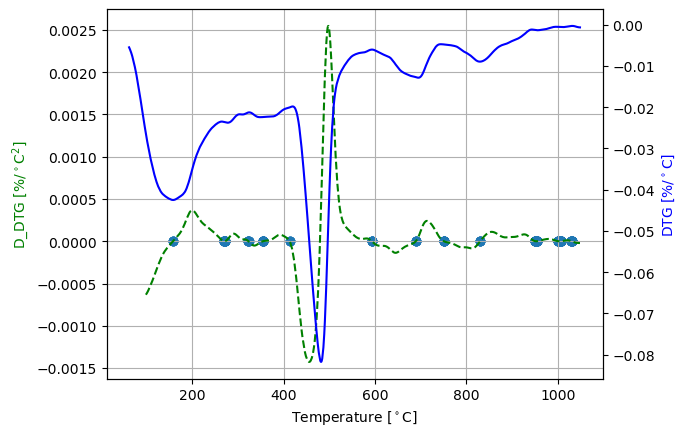

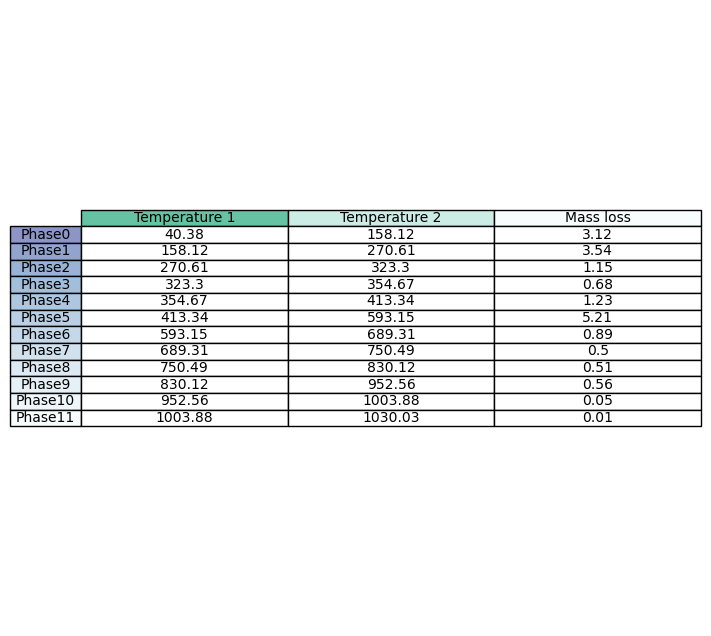

please input the phase number that you are interested in (see table) Input as an integer: 5


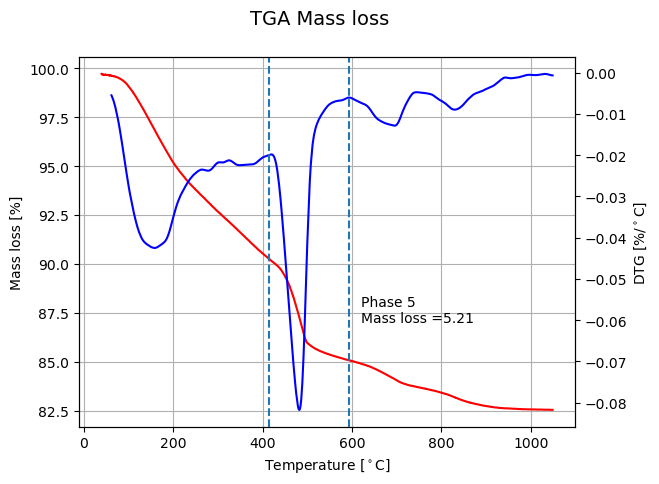

In [22]:
#main script

#read data from csv files
headers = ['Temp','Time','DSC','Mass','Gas1','Gas2','Gas 3','DTG','sensitivity']
df = pd.read_csv('ExpDat.csv', encoding="ISO-8859-1", dtype=float , skiprows=27, names=headers)
df2 = pd.read_csv('ExpDat_CA_FeCN_7030-2.csv', encoding="ISO-8859-1", dtype=float , skiprows=27, names=headers)

#Execute script
CEMI_data=computeTGA(df)

Help on function computeTGA in module __main__:

computeTGA(TGA_data)
    Input data from the csv file. Computes TGA derivatives. Classifies phase
    The calculates the mass loss and provides a plot

